In [145]:
# iMPORT PACKAGES
import pandas as pd
import datetime as dt
import numpy as np

from datetime import timedelta

import matplotlib.pyplot as plt

import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from time import time

# for multivariate data preparation
from numpy import array
from numpy import hstack

In [146]:
# fix random seed for reproducibility
np.random.seed(7)

In [313]:
# READ FILE
path = '/Users/cathytol/Documents/DMT/DMT/'
inputPath = path + "out_without_nan_mood_target_normalised.csv"
df = pd.read_csv(inputPath)
df['date'] = pd.to_datetime(df['date'])


In [314]:
df.head()

,id,date,activity_mean,circumplex.arousal_mean,circumplex.valence_mean,mood_mean,appCat.builtin_sum,appCat.communication_sum,appCat.entertainment_sum,appCat.finance_sum,...,appCat.travel_sum_time_5,appCat.unknown_sum_time_5,appCat.utilities_sum_time_5,appCat.weather_sum_time_5,call_sum_time_5,screen_sum_time_5,sms_sum_time_5,day_time_5,weekDay_time_5,mood_mean_TARGET
0,AS14.01,2014-02-25,0.000000,0.5000,0.384615,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.215385,0.000000,0.152174,0.040000,0.625000,6.250000
1,AS14.01,2014-02-26,0.000000,0.4375,0.615385,0.513158,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.123077,0.000000,0.152174,0.052727,0.625000,6.333333
2,AS14.01,2014-03-20,0.144034,0.5000,0.384615,NaN,0.006174,0.104651,0.009763,0.000000,...,0.000000,0.012146,0.004709,0.0,0.046154,0.025445,0.130435,0.263636,0.500000,6.200000
3,AS14.01,2014-03-21,0.236766,0.5500,0.446154,0.505263,0.077850,0.303150,0.028033,0.037502,...,0.067479,0.012146,0.138491,0.0,0.138462,0.226449,0.065217,0.272727,0.416667,6.400000
4,AS14.01,2014-03-22,0.418390,0.6500,0.538462,0.536842,0.018139,0.239538,0.002597,0.015953,...,0.070228,0.012146,0.164772,0.0,0.184615,0.295118,0.065217,0.281818,0.625000,6.800000


In [315]:
df = df.dropna(subset = ['mood_mean','mood_mean_TARGET'] ).reset_index(drop=True)

In [316]:
# Create test and train set by date
df = df.sort_values(by=['date'])
length_train = round(len(df)*0.67)
train = df[:length_train]
test = df[length_train:]
print(len(test), len(train))

401 815


In [150]:
# Create test and train set randomly
length_test = round(len(df)*0.33)
index_test = np.random.choice(np.arange(len(df)), length_test, False)

test = df.iloc[index_test]
train = df.drop(df.index[index_test])

In [151]:
#test.to_csv("test_set", index = False)
#train.to_csv("train_set", index = False)

In [152]:
test = pd.read_csv("test_set.csv")
train = pd.read_csv("train_set.csv")

In [252]:
train.head()

,id,date,activity_mean,circumplex.arousal_mean,circumplex.valence_mean,mood_mean,appCat.builtin_sum,appCat.communication_sum,appCat.entertainment_sum,appCat.finance_sum,...,appCat.travel_sum_time_5,appCat.unknown_sum_time_5,appCat.utilities_sum_time_5,appCat.weather_sum_time_5,call_sum_time_5,screen_sum_time_5,sms_sum_time_5,day_time_5,weekDay_time_5,mood_mean_TARGET
640,AS14.17,2014-04-06,0.065154,0.5625,0.769231,0.671053,0.003665,0.032363,0.050745,0.000000,...,0.021730,0.000000,0.020395,0.000000,0.092308,0.306988,0.130435,0.418182,0.833333,7.00
1022,AS14.29,2014-04-06,0.202475,0.5000,0.630769,0.750000,0.006000,0.103383,0.000000,0.000000,...,0.087393,0.000000,0.006521,0.000000,0.015385,0.301549,0.217391,0.418182,0.833333,7.20
773,AS14.23,2014-04-06,0.535670,0.5000,0.569231,0.631579,0.022588,0.389424,0.111625,0.000000,...,0.109478,0.060825,0.005832,0.000000,0.169231,0.645240,0.043478,0.418182,0.833333,5.75
533,AS14.15,2014-04-06,0.011620,0.4500,0.384615,0.505263,0.005589,0.009568,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.307692,0.031870,0.043478,0.418182,0.833333,6.80
350,AS14.09,2014-04-07,0.137988,0.3750,0.384615,0.505263,0.004330,0.127200,0.046123,0.057783,...,0.157147,0.022679,0.005902,0.219644,0.092308,0.346712,0.021739,0.427273,0.750000,7.20


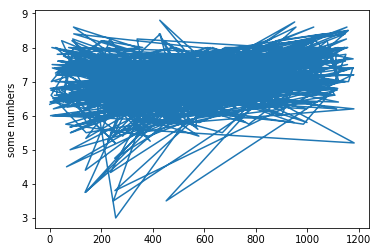

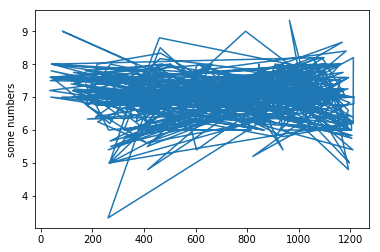

In [317]:
import matplotlib.pyplot as plt
plt.plot(train['mood_mean_TARGET'])
plt.ylabel('some numbers')
plt.show()

plt.plot(test['mood_mean_TARGET'])
plt.ylabel('some numbers')
plt.show()

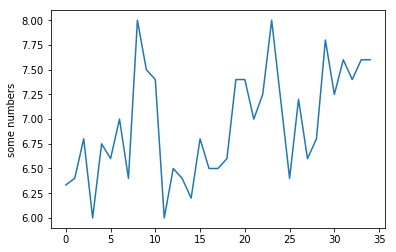

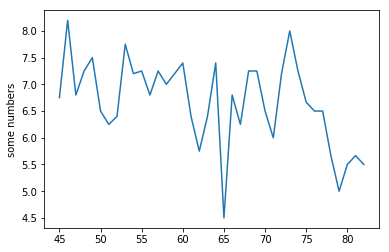

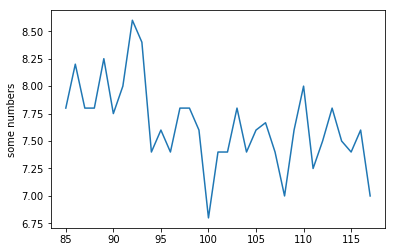

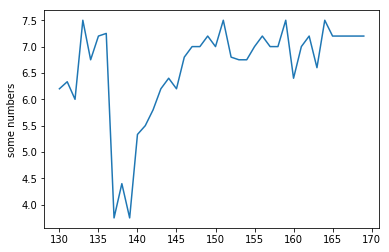

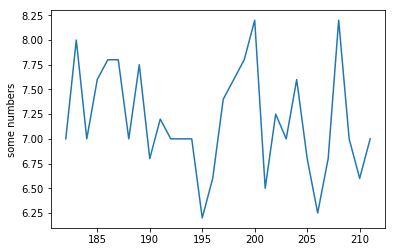

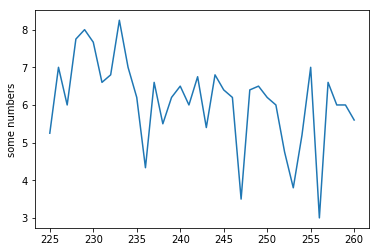

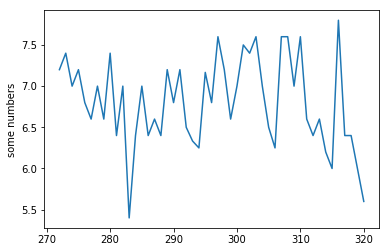

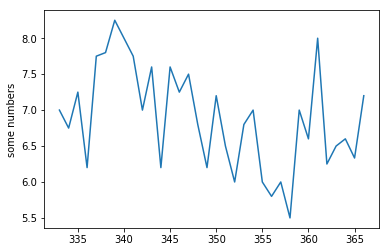

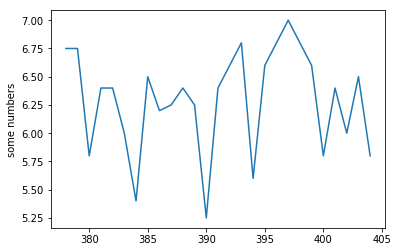

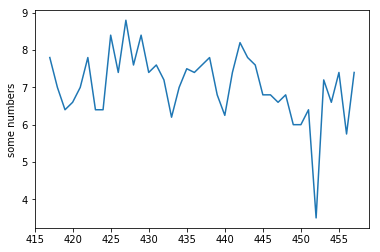

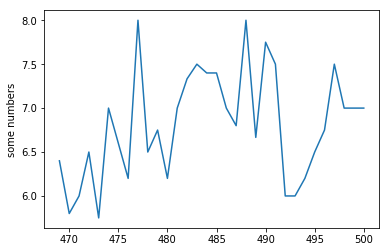

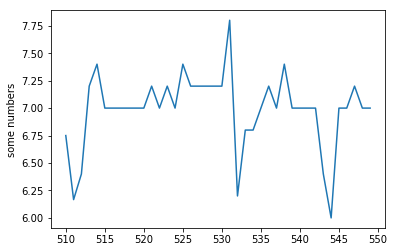

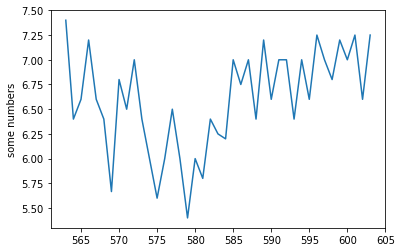

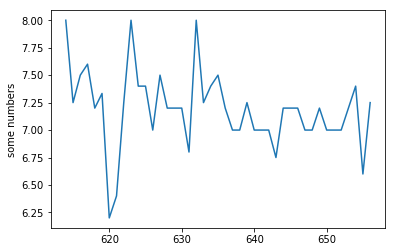

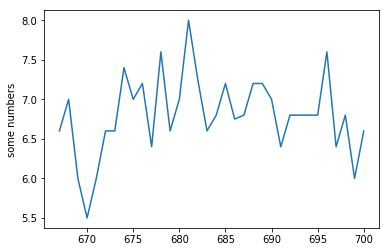

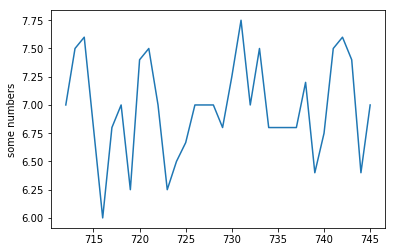

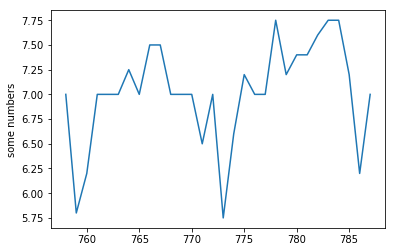

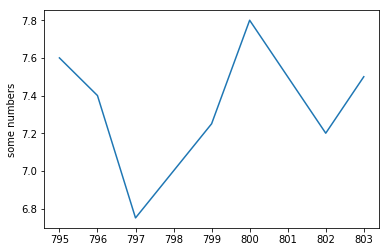

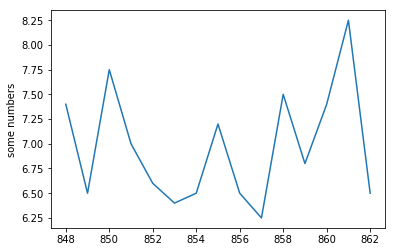

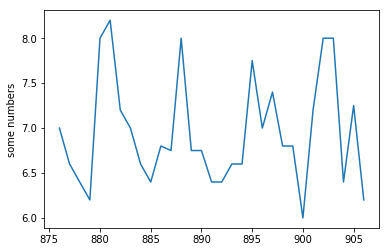

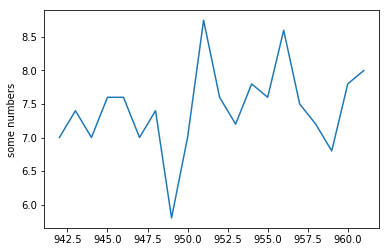

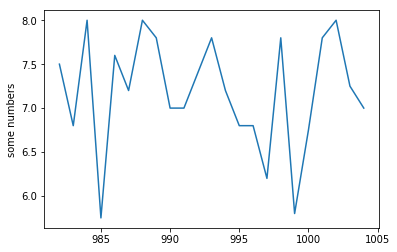

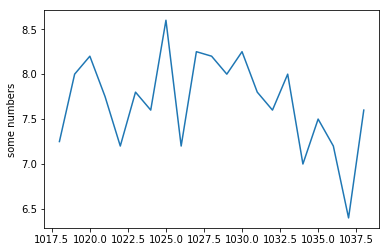

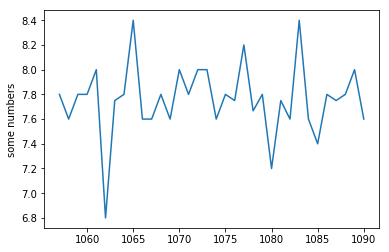

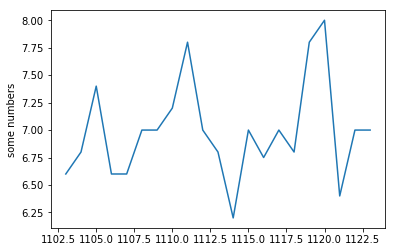

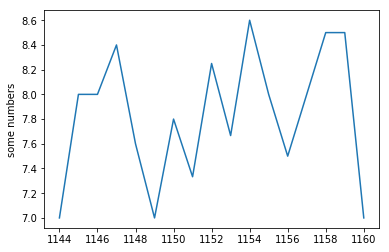

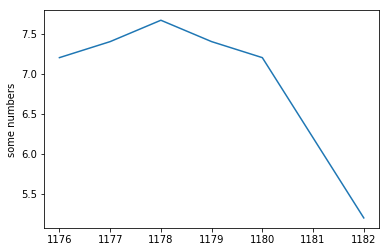

In [339]:
for name, group in train.groupby('id'):
    plt.plot(group['mood_mean_TARGET'])
    plt.ylabel('some numbers')
    plt.show()
    

In [154]:
#list(train.columns)

In [155]:
#test[['id','date','mood_mean', 'mood_mean_TARGET']].head(40)

In [325]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for name, group in dataset.groupby('id'):
        x = list(group['mood_mean'])
        y = list(group['mood_mean_TARGET'])
        for i in range(len(group)-look_back):
            dataX.append(x[i:(i+look_back)])
            dataY.append(y[i + look_back-1])
    return np.array(dataX), np.array(dataY)


look_back = 3
trainX, trainY = create_dataset(train[['id', 'mood_mean', 'mood_mean_TARGET']], look_back)
testX, testY = create_dataset(test[['id', 'mood_mean', 'mood_mean_TARGET']], look_back)


In [326]:
len(trainX)

734

In [327]:
len(testX)

321

In [159]:
""" 
trainX = np.array([train['mood_mean']])
trainY = np.array([train['mood_mean_TARGET']])

testX = np.array([test['mood_mean']])
testY = np.array([test['mood_mean_TARGET']])
"""

" \ntrainX = np.array([train['mood_mean']])\ntrainY = np.array([train['mood_mean_TARGET']])\n\ntestX = np.array([test['mood_mean']])\ntestY = np.array([test['mood_mean_TARGET']])\n"

In [328]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX.shape

(734, 1, 3)

In [337]:
t = time()

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)


print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Epoch 1/15
 - 6s - loss: 25.2674
Epoch 2/15
 - 2s - loss: 1.7488
Epoch 3/15
 - 2s - loss: 0.4846
Epoch 4/15
 - 2s - loss: 0.4489
Epoch 5/15
 - 2s - loss: 0.4358
Epoch 6/15
 - 2s - loss: 0.4290
Epoch 7/15
 - 2s - loss: 0.4246
Epoch 8/15
 - 2s - loss: 0.4207
Epoch 9/15
 - 2s - loss: 0.4177
Epoch 10/15
 - 2s - loss: 0.4178
Epoch 11/15
 - 2s - loss: 0.4138
Epoch 12/15
 - 2s - loss: 0.4129
Epoch 13/15
 - 2s - loss: 0.4113
Epoch 14/15
 - 2s - loss: 0.4072
Epoch 15/15
 - 2s - loss: 0.4104
Time to train the model: 0.53 mins


In [338]:
t = time()

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
trainScore = mean_squared_error(trainY, trainPredict[:,0])
print('Train Score: %.3f MSE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
testScore = mean_squared_error(testY, testPredict[:,0])
print('Test Score: %.3f MSE' % (testScore))

print('Time to predict: {} mins'.format(round((time() - t) / 60, 2)))

Train Score: 0.406 MSE
Test Score: 0.395 MSE
Time to predict: 0.03 mins


In [334]:
meanY = sum(trainY)/len(trainY)
SStotal = 0
SSres = 0
for value, f in zip(trainY, list(trainPredict[:,0])):
    SStotal += math.pow(value-meanY,2)
    SSres += math.pow(value-f,2)

print("R2 of train: ", 1-SSres/SStotal)


meanY = sum(testY)/len(testY)
SStotal = 0
SSres = 0
for value, f in zip(testY, list(testPredict[:,0])):
    SStotal += math.pow(value-meanY,2)
    SSres += math.pow(value-f,2)

print("R2 of test: ", 1-SSres/SStotal)



R2 of train:  0.2607892758584207
R2 of test:  0.19332346859954785


In [164]:
# Create empty df to save solutions
solutionsTrain = pd.DataFrame(data={'id': [], 'date': [], 'mood_mean_target': [], 'predicted_mood_mean_target':[]})

# Save solutions in df 
j = 0
for name, group in train.groupby('id'):
    for i in range(look_back-1, len(group)-1):
        #print(j, i)
        solutionsTrain = solutionsTrain.append({'id': group.iloc[i]['id'], 'date': group.iloc[i]['date'], 'mood_mean_target': group.iloc[i]['mood_mean_TARGET'],
                                      'predicted_mood_mean_target': trainPredict[j]}, ignore_index=True)
        j += 1   
        

# Create empty df to save solutions
solutionsTest = pd.DataFrame(data={'id': [], 'date': [], 'mood_mean_target': [], 'predicted_mood_mean_target':[]})

# Save solutions in df 
j = 0
for name, group in test.groupby('id'):
    for i in range(look_back-1, len(group)-1):
        #print(j, i)
        solutionsTest = solutionsTest.append({'id': group.iloc[i]['id'], 'date': group.iloc[i]['date'], 'mood_mean_target': group.iloc[i]['mood_mean_TARGET'],
                                      'predicted_mood_mean_target': testPredict[j]}, ignore_index=True)
        j += 1 

In [165]:
############################### multi variate

In [261]:
def create_dataset2(dataset, look_back=1):
    dataX, dataY = [], []
    for name, group in dataset.groupby('id'):
        #define input sequences
        in_seq1 = array(list(group['mood_mean']))
        in_seq2 = array(list(group['circumplex.valence_mean']))
        out_seq = array(list(group['mood_mean_TARGET']))
        #out_seq = list(group['mood_mean_TARGET'])
        #out_seq = array(out_seq[1:] + [np.nan])
        
        # convert to [rows, columns] structure
        in_seq1 = in_seq1.reshape((len(in_seq1), 1))
        in_seq2 = in_seq2.reshape((len(in_seq2), 1))
        out_seq = out_seq.reshape((len(out_seq), 1))
        # horizontally stack columns
        dataset = hstack((in_seq1, in_seq2, out_seq))
        
        for i in range(len(group)-look_back):
            dataX.append(dataset[i:i+look_back, :-1])
            dataY.append(dataset[i+look_back-1, -1])
    return np.array(dataX), np.array(dataY)


look_back = 3
trainX, trainY = create_dataset2(train[['id', 'mood_mean', 'circumplex.valence_mean', 'mood_mean_TARGET']], look_back)
testX, testY = create_dataset2(test[['id', 'mood_mean', 'circumplex.valence_mean', 'mood_mean_TARGET']], look_back)

In [262]:
t = time()

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 2)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(trainX, trainY, epochs=50, verbose=2)

print('Time to train: {} mins'.format(round((time() - t) / 60, 2)))

Epoch 1/50
 - 4s - loss: 47.4363
Epoch 2/50
 - 0s - loss: 44.1896
Epoch 3/50
 - 0s - loss: 37.3986
Epoch 4/50
 - 0s - loss: 19.1312
Epoch 5/50
 - 0s - loss: 2.2384
Epoch 6/50
 - 0s - loss: 1.4371
Epoch 7/50
 - 0s - loss: 1.2750
Epoch 8/50
 - 0s - loss: 1.2358
Epoch 9/50
 - 0s - loss: 1.1830
Epoch 10/50
 - 0s - loss: 1.1392
Epoch 11/50
 - 0s - loss: 1.0869
Epoch 12/50
 - 0s - loss: 1.0283
Epoch 13/50
 - 0s - loss: 0.9700
Epoch 14/50
 - 0s - loss: 0.9131
Epoch 15/50
 - 0s - loss: 0.8551
Epoch 16/50
 - 0s - loss: 0.7950
Epoch 17/50
 - 0s - loss: 0.7192
Epoch 18/50
 - 0s - loss: 0.6509
Epoch 19/50
 - 0s - loss: 0.5910
Epoch 20/50
 - 0s - loss: 0.5404
Epoch 21/50
 - 0s - loss: 0.5017
Epoch 22/50
 - 0s - loss: 0.4654
Epoch 23/50
 - 0s - loss: 0.4484
Epoch 24/50
 - 0s - loss: 0.4334
Epoch 25/50
 - 0s - loss: 0.4611
Epoch 26/50
 - 0s - loss: 0.4289
Epoch 27/50
 - 0s - loss: 0.4234
Epoch 28/50
 - 0s - loss: 0.4392
Epoch 29/50
 - 0s - loss: 0.4281
Epoch 30/50
 - 0s - loss: 0.4256
Epoch 31/50
 - 

In [263]:
YhatsTrain = []
for x in trainX:
    x = x.reshape((1, look_back, 2))
    y = model.predict(x, verbose = 0)
    YhatsTrain += [y[0][0]]

YhatsTest = []
for x in testX:
    x = x.reshape((1, look_back, 2))
    y = model.predict(x, verbose = 0)
    YhatsTest += [y[0][0]]



In [264]:
trainScore = mean_squared_error(trainY, YhatsTrain)
print('Train Score: %.3f MSE' % (trainScore))
testScore = mean_squared_error(testY, YhatsTest)
print('Test Score: %.3f MSE' % (testScore))

Train Score: 0.418 MSE
Test Score: 0.418 MSE


In [265]:
meanY = sum(trainY)/len(trainY)
SStotal = 0
SSres = 0
for value, f in zip(trainY, YhatsTrain):
    SStotal += math.pow(value-meanY,2)
    SSres += math.pow(value-f,2)

print("R2 of train: ", 1-SSres/SStotal)


meanY = sum(testY)/len(testY)
SStotal = 0
SSres = 0
for value, f in zip(testY, YhatsTest):
    SStotal += math.pow(value-meanY,2)
    SSres += math.pow(value-f,2)

print("R2 of test: ", 1-SSres/SStotal)

R2 of train:  0.24532424581493917
R2 of test:  0.24532424581493917


In [ ]:
# Create empty df to save solutions
solutionsTrain = pd.DataFrame(data={'id': [], 'date': [], 'mood_mean_target': [], 'predicted_mood_mean_target':[]})

# Save solutions in df 
j = 0
for name, group in train.groupby('id'):
    for i in range(look_back-1, len(group)-1):
        #print(j, i)
        solutionsTrain = solutionsTrain.append({'id': group.iloc[i]['id'], 'date': group.iloc[i]['date'], 'mood_mean_target': group.iloc[i]['mood_mean_TARGET'],
                                      'predicted_mood_mean_target': YhatsTrain[j]}, ignore_index=True)
        j += 1   
        

# Create empty df to save solutions
solutionsTest = pd.DataFrame(data={'id': [], 'date': [], 'mood_mean_target': [], 'predicted_mood_mean_target':[]})

# Save solutions in df 
j = 0
for name, group in test.groupby('id'):
    for i in range(look_back-1, len(group)-1):
        #print(j, i)
        solutionsTest = solutionsTest.append({'id': group.iloc[i]['id'], 'date': group.iloc[i]['date'], 'mood_mean_target': group.iloc[i]['mood_mean_TARGET'],
                                      'predicted_mood_mean_target': YhatsTest[j]}, ignore_index=True)
        j += 1 

In [ ]:
def calculateAccMSQ(solutions, name_target,name_predicted):
    correct = 0
    squared_error = 0

    for index, row in solutions.iterrows():
        squared_error += math.pow(row[name_target]-row[name_predicted],2)
        if (row[name_target] == row[name_predicted]):
            correct = correct + 1
        
    accuracy = correct/ len(solutions.index)
    msq = squared_error / len(solutions.index)
    return accuracy, msq

In [ ]:
print("TRAIN")
accuracy, msq = calculateAccMSQ(solutionsTrain, "mood_mean_target", "predicted_mood_mean_target")
print("acc, msq: ")
print(accuracy, msq)
print("rmse: ", math.sqrt(msq))

solutionsTrain2 = solutionsTrain.round({'mood_mean_target': 0, 'predicted_mood_mean_target': 0})
accuracy, msq = calculateAccMSQ(solutionsTrain2, "mood_mean_target", "predicted_mood_mean_target")
print("acc, msq: ")
print(accuracy, msq)
print("rmse: ", math.sqrt(msq))

print(" ")
print("TEST")
accuracy, msq = calculateAccMSQ(solutionsTest, "mood_mean_target", "predicted_mood_mean_target")
print("acc, msq: ")
print(accuracy, msq)
print("rmse: ", math.sqrt(msq))

solutionsTest2 = solutionsTest.round({'mood_mean_target': 0, 'predicted_mood_mean_target': 0})
accuracy, msq = calculateAccMSQ(solutionsTest2, "mood_mean_target", "predicted_mood_mean_target")
print("acc, msq: ")
print(accuracy, msq)
print("rmse: ", math.sqrt(msq))

In [ ]:
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/